Image Classification Tutorial {#vision__classification_tutorial}
=============================

In this tutorial, you will learn how to validate your **classification
model** using deepchecks test suites. You can read more about the
different checks and suites for computer vision use cases at the
`examples section  <vision__checks_gallery>`{.interpreted-text
role="ref"}.

A classification model is usually used to classify an image into one of
a number of classes. Although there are multi label use-cases, in which
the model is used to classify an image into multiple classes, most
use-cases require the model to classify images into a single class.
Currently, deepchecks supports only single label classification (either
binary or multi-class).

``` {.bash}
# Before we start, if you don't have deepchecks vision package installed yet, run:
import sys
!{sys.executable} -m pip install "deepchecks[vision]" --quiet --upgrade # --user

# or install using pip from your python environment
```


Defining the data and model
===========================

::: {.note}
::: {.title}
Note
:::

In this tutorial, we use the pytorch to create the dataset and model. To
see how this can be done using tensorflow or other frameworks, please
visit the
`creating VisionData guide <vision__vision_data_class>`{.interpreted-text
role="ref"}.
:::


Downloading the dataset
=======================

The data is available from the torch library. We will download and
extract it to the current directory.


In [1]:
import os
import numpy as np

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data. The model we are building will learn to classify **ants** and
**bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. This dataset is a very
small subset of imagenet.


In [2]:
train_data_dir = "/home/vishesh/Desktop/datasets/ships-data/X_true_train_240_320"
train_ground_truth_dir = "/home/vishesh/Desktop/datasets/ships-data/Y_true_train_240_320"

test_data_path = "/home/vishesh/Desktop/datasets/ships-data/X_true_val_240_320/1.npy"
test_ground_truth_path = "/home/vishesh/Desktop/datasets/ships-data/Y_true_val_240_320/1.npy"

perturbation = "shot_noise"
strength = 2
perturbed_dataset_path = f"/home/vishesh/Desktop/datasets/ships-data/perturbed_test/varying/{perturbation}/{strength}/1.npy"

In [3]:
X_train = None
y_train = None


for i in range(1,11):
    print(i)
    input_data_path = os.path.join(train_data_dir, f"{i}.npy")
    ground_truth_path = os.path.join(train_ground_truth_dir, f"{i}.npy")
    
    if i == 1:
        X_train = np.load(input_data_path)
        y_train = np.load(ground_truth_path)
        continue
        
        
    new_input_data = np.load(input_data_path)
    new_ground_truth = np.load(ground_truth_path)
    

    X_train = np.vstack((X_train, new_input_data))
    y_train = np.hstack((y_train, new_ground_truth))
    
y_train = y_train.astype(int)

1
2
3
4
5
6
7
8
9
10


In [4]:
# X_test = np.load(test_data_path)
y_test = np.load(test_ground_truth_path).astype(int)

perturbed_dataset = np.load(perturbed_dataset_path)
X_test = perturbed_dataset

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Visualize the dataset
=====================

Let\'s see how our data looks like.


In [5]:
print(f'Number of training images: {X_train.shape[0]}')
print(f'Number of validation images: {X_test.shape[0]}')
print(f'Example output of an image shape: {X_train[0].shape}')
print(f'Example output of a label: {y_train[0]}')

Number of training images: 10000
Number of validation images: 1000
Example output of an image shape: (240, 320, 3)
Example output of a label: 3


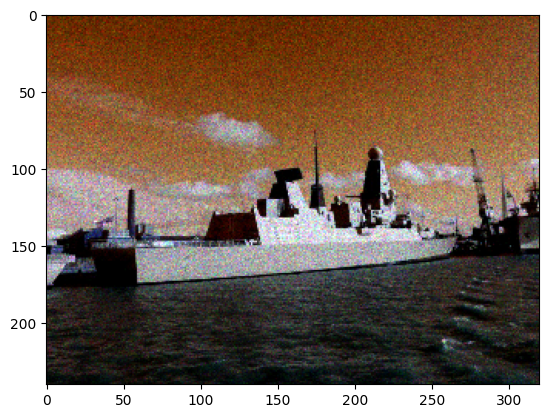

In [6]:
import matplotlib.pyplot as plt

plt.imshow(X_test[10])

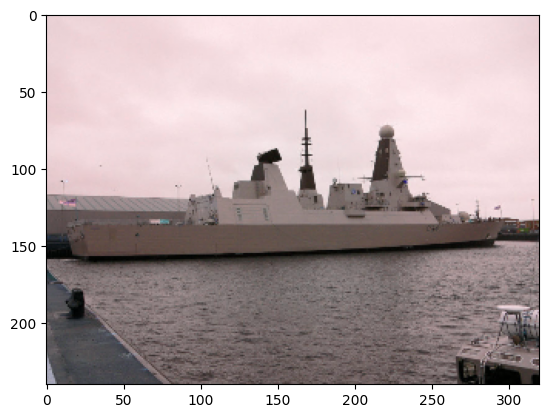

In [7]:
plt.imshow(X_train[2])

Downloading a pre-trained model
===============================

Now, we will download a pre-trained model from torchvision, that was
trained on the ImageNet dataset.


In [8]:
# import tensorflow as tf
# import tensorflow_addons as tfa

# model = tf.keras.models.load_model("/home/vishesh/Desktop/datasets/ships-data/Xception-10-0.74.hdf5", compile=False)
# model.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='categorical_crossentropy')

In [9]:
# test_preds = model.predict(test_dataset)

Validating the Model with Deepchecks
====================================

Now, after we have the training data, validation data and the model, we
can validate the model with deepchecks test suites.

Implementing the VisionData class
---------------------------------

The checks in the package validate the model & data by calculating
various quantities over the data, labels and predictions. In order to do
that, those must be in a pre-defined format, according to the task type.
In the following example we\'re using pytorch. To see an implementation
of this in tensorflow, please refer to the
`vision__vision_data_class`{.interpreted-text role="ref"} guide. For
pytorch, we will use our DataLoader, but we\'ll create a new collate
function for it, that transforms the batch to the correct format. Then,
we\'ll create a
`deepchecks.vision.vision_data.vision_data.VisionData`{.interpreted-text
role="class"} object, that will hold the data loader.

To learn more about the expected formats, please visit the
`vision__supported_tasks`{.interpreted-text role="ref"}.

First, we\'ll create the collate function that will be used by the
DataLoader. In pytorch, the collate function is used to transform the
output batch to any custom format, and we\'ll use that in order to
transform the batch to the correct format for the checks.


In [10]:
def custom_generator(images, labels, batch_size = 64):
    for i in range(0, len(images), batch_size):
        
        images_in_batch = images[i:i+batch_size]
        labels_in_batch = labels[i:i+batch_size]
#         preds_in_batch = preds[i:i+batch_size]
        
        images_in_batch = (images_in_batch * 255).astype(np.uint8)
        yield BatchOutputFormat(images=images_in_batch, labels=labels_in_batch)



We have a single label here, which is the tomato class The label\_map is
a dictionary that maps the class id to the class name, for display
purposes.


In [11]:
LABEL_MAP = {0: "Carrier", 
             1: "CombatVessel", 
             2: "Container", 
             3: "Passenger", 
             4: "Ro-ro", 
             5: "Tanker", 
             6: "Tug", 
             7: "Vessel", 
             8: "Yacht"}

Now that we have our updated collate function, we can recreate the
dataloader in the deepchecks format, and use it to create a VisionData
object:


In [12]:
from deepchecks.vision import VisionData, BatchOutputFormat

training_data = VisionData(custom_generator(X_train, y_train), task_type='classification', reshuffle_data=True)
test_data = VisionData(custom_generator(X_test, y_test), task_type='classification', reshuffle_data=True)

deepchecks - WARNING - Shuffling is not supported for received batch loader. Make sure that your provided batch loader is indeed shuffled and set shuffle_batch_loader=False
deepchecks - WARNING - Shuffling is not supported for received batch loader. Make sure that your provided batch loader is indeed shuffled and set shuffle_batch_loader=False


Making sure our data is in the correct format:
==============================================

The VisionData object automatically validates your data format and will
alert you if there is a problem. However, you can also manually view
your images and labels to make sure they are in the correct format by
using the `head` function to conveniently visualize your data:


In [13]:
# test_data.head()

And observe the output:

Running Deepchecks\' suite on our data and model!
=================================================

Now that we have defined the task class, we can validate the train and
test data with deepchecks\' train test validation suite. This can be
done with this simple few lines of code:


In [14]:
from deepchecks.vision.suites import train_test_validation

suite = train_test_validation()
result = suite.run(training_data, test_data,  max_samples = 5000)

We also have suites for:
`data integrity <deepchecks.vision.suites.data_integrity>`{.interpreted-text
role="func"} - validating a single dataset and
`model evaluation <deepchecks.vision.suites.model_evaluation>`{.interpreted-text
role="func"} -evaluating the model\'s performance.


Observing the results:
======================

The results can be saved as a html file with the following code:


In [15]:
result

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_XAJI0Y6DPBHSAHXTHV3A3ZMF8">Train Test Validat…

We can see that we do not have any meaningful issues with our data, and
although there\'s some drift between the train and test datasets (under
the \"Passed\" section), this is not significant enough to cause any
issues (and therefor is not displayed in the \"Didn\'t Pass\" section).
However, under the \"Other\" section, that details checks without a
specific pass/fail condition, we can see that the heatmap of brightness
in the images is not uniformly distributed, which means that in most
images, there are brighter objects in the center of the image. This
makes sense as these images of bees and ants tend to have the insects in
the center of the image, but it is something to be aware of and maybe
use data augmentation to fix.
